# Text Mining Project


### INTRODUCTION 
Market share growth is expected to be highly influenced by the company’s well generating great insights into customer voice and initiating changes. In order to have a good understanding of customer voice, the team was motivated to perform some text mining techniques on an oral care brand of a pharmaceutical company. We will call this as Brand A within the scope of this notebook. <br/>

The study serves two purposes: <br/>
- To extract customer insights related to overall brand perception and its product features that receive top attention from customers. <br/>
- To visualize customer perceptions about brands across the oral care sector to understand how Brand A is positioned against its competitors. <br/>

These two objectives bring the team to the final goal of helping the company to understand how customers communicate about the brand and where perception or performance could be improved.

### DATA OVERVIEW
As part of the project, the team utilized two datasets, BazaarVoice and Brandwatch. The table below summarizes several key information. <br/>

|           | BazaarVoice  |  Brandwatch |
---|:---:|:---:|
**Sources**| reviews on the brand website|social media posts that mention the products (Twitter, Tumbler, etc.)
|       |                             |reviews on other vendor platforms (Amazon, Costco, etc.)
**Brands** | BrandA | BrandA & 20 competitors
**Time Period**|01.2018-06.2020|01.2018-06.2020 for BrandA
 |       |   |01.2018-04.2020 for others
**Data Size**|8,591|241,339
**Labelled - Category**| Yes | No
**Ratings provided**|Yes|No

<br/>
Basically, what the team would do is to combine the two datasets before drilling down into how the customers perceive current oral care products. However, there are several differences between the two datasets that are worth noting before they can be combined.<br/>
- The team noted that Brandwatch dataset does not have information on BrandA product category and ratings as the BazaarVoice dataset. Therefore, the team would need to find a way to fill out these missing information so that the two datasets can be combined. <br/>
- While BazaarVoice dataset is comprised of only product reviews on BrandA website, Brandwatch dataset includes two types of information. Besides product reviews on different vendor websites like Amazon, Walmart, Target, etc., social media posts or comments that mention products under selected oral care brands are also included. This alerts the team that a number of texts is highly likely to not be true product reviews; instead, they can be promotional posts or simply posts that mention products for other purposes like entertaining, etc. Therefore, while assigning sentiment to Brandwatch texts, the team paid attention to assigning “Neutral” voice besides “Negative” and “Positive” to reduce the impact of such non-review texts. <br/>
- The time period for BrandA and other brands are different. While data for BrandA ranges from Jan 2018 to Jun 2020, data for competitor brands ends in Apr 2020. The team noted this for the comparison between BrandA and other brands. <br/>
<br/>
By looking more into the dataset, the team also noted that Brandwatch dataset comes with a lot of noise that needs to be dealt with before analysis. The noise may arise from the fact that the data was pulled from social media and vendor platforms by some certain engines. Below are some sample reviews from the two datasets. <br/>

*(branda.com) Please bring it back! It's the only one I like. Finding a replacement will be difficult. <br/>
(Amazon) n n Terrible floss, falls apart too easily n n<br/>
(Twitter) RT @RisasDental Is your oral health a part of your New Year's resolutions? Here's a list of the best foods for a healthy smile to start off the year.* <br/>

As can be from the samples, compared to BazarVoice texts which are customer reviews on BrandA websites with more “proper” language, Brandwatch texts have more noise and requires cleaning, and also, lots of slangs are used in social media posts. Plus, there are lots of duplicates in Brandwatch dataset that are “disguised” by retweet feature and special characters.


### METHODOLOGY
After investigating the data, the team performed necessary steps below to move the project forward. <br/>
**Step 1:** Pre-process data <br/>
The first step is to clean the data. The team did necessary pre-processing tasks such as removing duplicates, removing promotional content, etc. <br/>
**Step 2:** Build models to fill out missing values <br/>
To combine two datasets, it was a must to assign sentiment to all Brandwatch texts and assign product category to all texts of BrandA in that dataset. The team built two models accordingly for this purpose. <br/>
**Step 3:** Generate insights <br/>
After having a complete and clean dataset, the team conducted three analyses on: <br/>
-sentiment across BrandA product categories; <br/>
-sentiment across brands in the oral care landscape; <br/>
-sentiment over top product feature.

Within this notebook, the analysis results will not be provided. Instead, I will walk you through the first two steps, on **how the team cleaned the data, build models to fill in missing values before combining the two datasets, and how to perform LDA modelling to understand the top discussed product features.**

In [ ]:
# load libraries
import pandas as pd
import numpy as np
from string import punctuation
from matplotlib import pyplot as plt
import re 

##### Load BazarVoice dataset

In [2]:
# load bazarvoice data
bazar = pd.read_csv("BazarVoice.csv", header = 0, engine='python')

# reformat date
bazar['lastmodificationtime'] = pd.to_datetime(bazar['lastmodificationtime'])

# use the "rating" column to assign a sentiment. 
# sentiment is positive if rating is 4 or 5, neutral if 3 and negative otherwise.
bazar["Sentiment"] = bazar['rating'].apply(lambda x: 'Negative' if x < 3 else ('Neutral' if x==3 else 'Positive'))

In [3]:
bazar.shape

(8591, 10)

In [ ]:
bazar.head(2)

I'm not allowed to share data here. So I just take 2 rows as examples. Product names are hidden in the demonstration.

|modificationstatus|lastmodificationtime|title|reviewtext|wordcloudtext|rating|reviewerlocation|productname|categoryname|Sentiment|
|---|---|---|---|---|---|---|---|---|---|
|APPROVED|2020-06-26|Great product|We bought this product and...|BOUGHT|5|USA|*productname*|Mouthwash...|Positive|
|REJECTED|2020-06-27|Burning feeling|I figured out I would weigh in here...|FIGURED|1|Philadelphia|*productname*|Mouthwash|Negative

##### Load & clean Brandwatch dataset

There are lots of texts in Brandwatch datasets to be duplicated in some ways. These can be divided into two main types. <br/>
The first type is texts that are technically the same but disguised by special characters and retweet features. Examples are as below. <br/>
*Sometimes when I watched the football match, I ... <br/>
**RT @chaddukes** Sometimes when I watched the football match, I ... <br/>*

*zuode: she gargled Â my balls like Â they were, Â <br/>
zuode: she gargled Â my balls like Â they were, Â **????** <br/>*
To deal with those duplicates, the team performed some steps, including removing @ mentions, removing URLs, removing special characters, removing leading and trailing spaces, etc. At this step, the dataset was reduced from 241,000 to 142,000 texts.

The second type of noise is that lots of texts seem to be promotional contents, and thus are similar but not 100% the same.<br/>
*...The best way to ensure strong dental #health is to take care of your #smile and visit* **Dr. June regularly:** https://t.co/rBfUrzsasadas  <br/>
*...The best way to ensure strong dental #health is to take care of your #smile and visit* **our #dentist regularly:** https://t.co/1gmyFas <br/>
To remove those texts, the team calculated pairwise cosine similarity and applied a threshold of 0.9 to remove texts that bear high resemblance. The team removed 10,000 texts and got the final Brandwatch dataset of 132,000.

In [5]:
# load brandwatch
bw18 = pd.read_csv("Brandwatch - 2018.csv", header = 0, engine='python')
bw19 = pd.read_csv("Brandwatch - 2019.csv", header = 0, engine='python')
bw20 = pd.read_csv("Brandwatch - 2020.csv", header = 0, engine='python')
brandwatch = pd.concat([bw18,bw19,bw20])
brandwatch = brandwatch.drop(columns=['query_name','city','region'])

# reformat some columns
brandwatch['full_text'] = brandwatch['full_text'].astype(str)
brandwatch['date'] = pd.to_datetime(brandwatch['date'])

In [6]:
brandwatch.shape

(241339, 3)

In [ ]:
brandwatch.head(2)




|brand|date|full_text|
|---|---|---|
BrandA|2018-12-30|RT @KevGBKNY I think that?s out your system....
BrandB|2018-12-30|I love these strips, but have had trouble find...

In [8]:
# CLEAN DATA
# remove usernames (any set of characters that start with @)
brandwatch["review_no@"] = brandwatch["full_text"].apply(lambda x: re.sub('@[\w]*',' ',str(x)))
# remove url
brandwatch["review_nourl"] = brandwatch["review_no@"].apply(lambda x: re.sub(r'http\S+', '', str(x)))
# lowercase 'reviewtext' - prepare for stopwords step
brandwatch["review_lower"] = brandwatch["review_nourl"].str.lower()
# remove 'rt'
brandwatch["review_nort"] = brandwatch["review_lower"].apply(lambda x: re.sub('rt',' ',str(x)))
# remove all special characters except for letters
brandwatch["review_letter"] = brandwatch["review_nort"].apply(lambda x: re.sub('[^a-zA-Z]',' ',x))
# remove leading & trailing spaces
brandwatch["reviewtext"] = brandwatch["review_letter"].apply(lambda x: x.strip())

In [9]:
# sort by date
brandwatch = brandwatch.sort_values('date')
# remove duplicates and keep the first text in case of duplicates
brandwatch=brandwatch.drop_duplicates(subset='reviewtext')
# part of analysis will be performed following review date; thus, it's important to keep the first one

In [10]:
# keep necessary columns only
brandwatch = brandwatch[['brand','date','reviewtext']]

In [11]:
import nltk # https://www.nltk.org/ ; nltk helps with tokenization, stopwords dictionary, lemmatization
from nltk.corpus import stopwords

# remove stop words - this step prepares for cosine similarity calculation
# download the stopwords dictionary
nltk.download('stopwords')

# save the list of stopwords in stop_words
sw = stopwords.words('english')
sw

# add extra words to the stopwords dictionary #after checking the list of stopwords
new_stopwords = ['guys','could', 'can t',"can't",'dont',
                 'tbh','b','c','e','f','g','h','j','k','l','n','p','q','r','u','v','w','x','z','da','lol'
                ] #to be added
sw.extend(new_stopwords)

# remove the words that exist in the stopwords dictionary from texts
brandwatch["reviewtext_nosw"] = brandwatch["reviewtext"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in sw))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ntkcu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# replace empty strings with NAs - a number of strings are empty after stopwords are removed
brandwatch['reviewtext_nosw'].replace('', np.nan, inplace=True)
# drop null values after removing stop words
brandwatch.dropna(subset=['reviewtext_nosw'], inplace=True)

In [13]:
# reset index
brandwatch=brandwatch.reset_index(drop=True)

In [ ]:
print(brandwatch.shape)
brandwatch.head(2)

|brand|date|reviewtext|reviewtext_nosw
|---|---|---|---|
BrandA|2018-01-01|read this a icle about a woman who cheats...|read icle woman cheats man...|
BrandA|2018-01-01|tide pod candy is so what s trendy for...|tide pod candy trendy clorox...|

##### Calculate cosine similarity among texts

In [17]:
# cosine similarity
df=pd.DataFrame(columns=['X','Y','cosine'])
list_x = []
list_y = []
list_cos = []

In [18]:
# sort dataset by brand - review_nosw - date for the similarity test
# reasons: sort by brand to just compare texts in the same brand
# sort by review_nosw cos' similar texts will be close to each other and usually starts with the same word
# sort by date so that the oldest one is kept to serve the purpose of review date analysis
brandwatch=brandwatch.sort_values(by=['brand','reviewtext_nosw','date'])
brandwatch=brandwatch.reset_index(drop=True)

*Cosine similarity code source:* [Source](https://www.geeksforgeeks.org/python-measure-similarity-between-two-sentences-using-cosine-similarity/)

In [19]:
from nltk.tokenize import word_tokenize 

# calculate cosine similiarity and list indexes of texts with high similiarity
threshold=brandwatch.index[-1]

for i in brandwatch.index:
    low = i+1
    high = i+16 # about 15 similar texts max - scanning the dataset to check 
                # no need to search for the whole dataset
    for j in range(low,high):
        if j < threshold: # set a limit to avoid range out of index
            if brandwatch.loc[i,'brand']==brandwatch.loc[j,'brand']:
                if j not in list_y: # no need to compare with the one that is already known to be removed         
                    X = brandwatch.loc[i,'reviewtext_nosw'].lower()
                    Y = brandwatch.loc[j,'reviewtext_nosw'].lower()
                    # tokenization 
                    X_list = word_tokenize(X)  
                    Y_list = word_tokenize(Y) 
        
                    l1 =[];l2 =[] 
    
                    # stop words from the string have been removed from previous steps
                    
                    X_set = set(X_list)
                    Y_set = set(Y_list)
    
                    # form a set containing keywords of both strings  
                    rvector = X_set.union(Y_set)  
                    for w in rvector: 
                        if w in X_set: l1.append(1) # create a vector 
                        else: l1.append(0) 
                        if w in Y_set: l2.append(1) 
                        else: l2.append(0) 
                    c = 0  
    
                    # cosine formula  
                    for u in range(len(rvector)): 
                            c+= l1[u]*l2[u] 
                    denominator = float((sum(l1)*sum(l2))**0.5)
                    if denominator != 0:
                        cosine = c / denominator 
    
                    if cosine >=0.9:
                        list_x.append(i)
                        list_y.append(j)
                        list_cos.append(cosine)
                    
df['X'],df['Y'],df['cosine'] = list_x,list_y,list_cos

In [20]:
df.shape

(9782, 3)

In [21]:
df.head()

,X,Y,cosine
0,29,30,0.942809
1,45,46,1.000000
2,76,77,1.000000
3,76,78,1.000000
4,76,79,1.000000


In [24]:
# remove rows that have high similarities, just keep first
brandwatch = brandwatch.loc[~brandwatch.index.isin(df['Y'])]

In [25]:
brandwatch.shape

(132273, 4)

In [ ]:
brandwatch['brand'].value_counts()

|brand|count|
|---|---:|
BrandA | 50299|
BrandB | 31449|
BrandC | 14950|
BrandD | 10352|
BrandE |  9337|
BrandF |  4650|
....
BrandN |   42|
BrandO |   15|

There is an unbalanced status in the number of reviews among brands. It should be noted for the sentiment analysis across brands in the oral care landscape.

In [153]:
#brandwatch.to_csv("brandwatch.csv")

### Predict Sentiment
The purpose is to assign sentiment to texts in Brandwatch dataset. <br/>
The team tried several different models to assign sentiment to Brandwatch texts. Several models gave good resuls on train and test data using BazarVoice dataset but predicted poorly on Brandwatch dataset when the team randomly
selected 300 texts and manually checked sentiment accuracy. The team finalized the sentiment assignment using Vader with accuracy level of 86%. Three classes of sentiment, including Negative, Neutral, and Positive were
assigned. A confusion matrix was generated using the result of 300 texts that were manually checked.

In [79]:
#pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
brandwatch['review_neg'] = [analyzer.polarity_scores(x)['neg'] for x in brandwatch['reviewtext']]
brandwatch['review_pos'] = [analyzer.polarity_scores(x)['pos'] for x in brandwatch['reviewtext']]
brandwatch['review_neu'] = [analyzer.polarity_scores(x)['neu'] for x in brandwatch['reviewtext']]
brandwatch.head(2)

|brand|date|reviewtext|reviewtext_nosw|review_neg|review_pos|review_neu|
|---|---|---|---|---:|---:|---:|
BrandX|2020-01-12|abc and cnn s repo ing was definitely skewed...|abc cnn repo ing skewed...|0.083|0.106|0.810
BrandX|2019-07-25|the ability to solve a problem act on it...|ability solve problem act rinse...|0.182|0.277|0.541

In [86]:
# assign the sentiment with the one with highest score
brandwatch['Max']=brandwatch[['review_neg','review_pos','review_neu']].idxmax(axis=1)
brandwatch['Max'].value_counts()

review_neu    126970
review_pos      4485
review_neg       818
Name: Max, dtype: int64

In [110]:
brandwatch['sentiment'] = brandwatch['Max'].apply(lambda x: 'Negative' if x=='review_neg' else ('Neutral' if x=='review_neu' else 'Positive'))
brandwatch['sentiment'].value_counts() # recheck if the assigment works

Neutral     126970
Positive      4485
Negative       818
Name: sentiment, dtype: int64

In [ ]:
brandwatch.head(2)

|brand|date|reviewtext|reviewtext_nosw|review_neg|review_pos|review_neu|Max|sentiment|
|---|---|---|---|---:|---:|---:|:---:|:---:|
BrandX|2020-01-12|abc and cnn s repo ing was definitely skewed...|abc cnn repo ing skewed...|0.083|0.106|0.810|review_neu|Neutral|
BrandX|2019-07-25|the ability to solve a problem act on it...|ability solve problem act rinse...|0.182|0.277|0.541|review_neu|Neutral

In [2]:
# randomly select 300 tests, 100 for each predicted class - to test accuracy
neutral = brandwatch.loc[brandwatch['sentiment']=='Neutral']
negative = brandwatch.loc[brandwatch['sentiment']=='Negative']
positive = brandwatch.loc[brandwatch['sentiment']=='Positive']

In [4]:
pos=positive.sample(100)
neg=negative.sample(100)
neu=neutral.sample(100)

In [ ]:
sample = pd.concat([pos,neg,neu]).reset_index(drop=True)

In [ ]:
# print to file
sample.to_csv("sentiment_test.csv")

In [ ]:
# manually assign sentiment for 300 random texts, 100 texts for each class prediction
# add the file back for confusion matrix
result = pd.read_csv("sentiment_test.csv")
result.head(2)

|brand|date|reviewtext|reviewtext_nosw|review_neg|review_pos|review_neu|Max|sentiment|manual
|---|---|---|---|---:|---:|---:|:---:|:---:|:---:|
BrandX|2020-01-12|abc and cnn s repo ing was definitely skewed...|abc cnn repo ing skewed...|0.083|0.106|0.810|review_neu|Neutral|Neutral
BrandX|2019-07-25|the ability to solve a problem act on it...|ability solve problem act rinse...|0.182|0.277|0.541|review_neu|Neutral|Neutral

In [12]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# create confusion matrix
print("Confusion Matrix:")
conf_mat = confusion_matrix(y_true=result['sentiment'], y_pred=result['manual'])
print(conf_mat)

print("Accuracy:", metrics.accuracy_score(result['sentiment'], result['manual']))

Confusion Matrix:
[[88  8  4]
 [10 84  6]
 [ 3 11 86]]
Accuracy: 0.86


The confusion matrix showed that Vader tended to predict more Neutral than Negative and Positive, which the team believed to be fair concerning the nature of Brandwatch dataset. Regarding BazarVoice, the team assigned reviews with 1-2 stars as Negative, 3 as Neutral and 4-5 as Positive. <br/>
By combining BazarVoice and Brandwatch, the team got a sentiment summary as below:<br/>

|sentiment|count|
|---|---:|
Negative|1,806
Neutral|127,488
Positive|10,866
**Total**|**140,160**

### Predict categories

To assign product category to BrandA texts in Brandwatch dataset, the team build a predictive model using word embeddings, training and testing on BazarVoice dataset by 70-30. The team performed modelling on 9 out of 13 categories and eliminated categories with too few samples.

In [27]:
# Combine texts from two datasets to create token list
bazar_list = bazar['reviewtext'].tolist()
bw_list = brandwatch['reviewtext'].tolist()
reviews = bazar_list + bw_list
df_reviews = pd.DataFrame({'review': reviews})
print(df_reviews.shape)
df_reviews.head(2)

(140864, 1)


,review
0,We bought this product and absolutely love it!...
1,I figured I would weigh in here regarding the ...


In [28]:
import tensorflow
import keras
from keras.preprocessing.text import Tokenizer

# create word index
tokenizer = Tokenizer() # Tokenizer(num_words = 5000) 
tokenizer.fit_on_texts(df_reviews["review"])
print(len(tokenizer.word_index))
tokenizer.document_count

94821


140864

In [ ]:
#tokenizer.word_index

In [ ]:
# count how many times each product category shows up
bazar['categoryname'].value_counts()

|category|count|
|---|---:|
Category 01|3727
Category 02|1069
Category 03|897
Category 04|749
Category 05|712
Category 06|626
Category 07|343
Category 08|246
Category 09|120
Category 10|40
Category 11|34
Category 12|26
Category 13|2

In [ ]:
# keep only the instances that have categories with at least 40 instances
bazar_2 = bazar.groupby('categoryname').filter(lambda x : len(x) > 40) 
bazar_2['categoryname'].value_counts()

In [51]:
# Convert categorical labels to numbers
Y_cat_df = pd.get_dummies(bazar_2['categoryname'])
Y_cat = Y_cat_df.values
print('Shape of label tensor:', Y_cat.shape)

Shape of label tensor: (8489, 9)


In [52]:
# create independent var
X_cat = tokenizer.texts_to_sequences(bazar_2["reviewtext"])
print(X_cat[0]) # print the first sequence of word indices
print(bazar_2["reviewtext"][0]) 

[64, 246, 14, 72, 3, 687, 105, 6, 6, 1875, 443, 3, 437, 20, 44, 143, 1138]
We bought this product and absolutely love it! It doesn't burn and leave your mouth taste nasty.


In [53]:
# Truncate and pad
from keras.preprocessing.sequence import pad_sequences

np.sum(num_tokens <= 110) / len(num_tokens) # 96% of the documents have at most 110 tokens

maximum_tokens = 110
X_cat = pad_sequences(X_cat, maxlen=maximum_tokens)
print('Shape of data tensor:', X_cat.shape)

Shape of data tensor: (8489, 110)


In [54]:
# Split train-test
from sklearn.model_selection import train_test_split  

x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, Y_cat, test_size=0.30, random_state=123)
print(x_train_cat.shape,y_train_cat.shape)
print(x_test_cat.shape,y_test_cat.shape)

(5942, 110) (5942, 9)
(2547, 110) (2547, 9)


*Code Ref:* [First](https://realpython.com/python-keras-text-classification/?fbclid=IwAR2c6b8oBdNsJ6pMUlzW0pkvokJs_9BXMc743t3643_jxjACsZz141MrLdQ) [Second](https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17) <br/>
By using Glove, accuracy increased from around 73% to 81% for test set; overfitting issue was fixed.

In [55]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [56]:
embedding_dim = 32
embedding_matrix = create_embedding_matrix(
     'glove.6B.50d.txt',tokenizer.word_index, embedding_dim)

In [57]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
num_words =  len(tokenizer.word_index) + 1
nonzero_elements / num_words

0.5974246482883719

In [58]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import layers

np.random.seed(123)
model_cat = Sequential()
num_words =  len(tokenizer.word_index) + 1
embedding_size = 32
model_cat.add(Embedding(input_dim=num_words, output_dim=embedding_size, input_length=maximum_tokens, name='embedding_layer',
                   weights=[embedding_matrix], 
                           trainable=True))
model_cat.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model_cat.add(layers.GlobalMaxPool1D())
model_cat.add(layers.Dense(9, activation='softmax'))
model_cat.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
batchsize = 32
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model_cat.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history_cat = model_cat.fit(x_train_cat, y_train_cat, batch_size=batchsize, validation_split=0.1, epochs=20,callbacks=[es, mc])

Epoch 1/20
168/168 [==============================] - ETA: 0s - loss: 1.7118 - accuracy: 0.4404
Epoch 00001: val_accuracy improved from -inf to 0.56303, saving model to best_model_cat.h5
168/168 [==============================] - 28s 166ms/step - loss: 1.7118 - accuracy: 0.4404 - val_loss: 1.4191 - val_accuracy: 0.5630
Epoch 2/20
168/168 [==============================] - ETA: 0s - loss: 1.3257 - accuracy: 0.5656
Epoch 00002: val_accuracy improved from 0.56303 to 0.62521, saving model to best_model_cat.h5
168/168 [==============================] - 28s 166ms/step - loss: 1.3257 - accuracy: 0.5656 - val_loss: 1.2284 - val_accuracy: 0.6252
Epoch 3/20
168/168 [==============================] - ETA: 0s - loss: 1.1280 - accuracy: 0.6325
Epoch 00003: val_accuracy improved from 0.62521 to 0.67731, saving model to best_model_cat.h5
168/168 [==============================] - 29s 173ms/step - loss: 1.1280 - accuracy: 0.6325 - val_loss: 1.0152 - val_accuracy: 0.6773
Epoch 4/20
168/168 [===========

In [59]:
accr = model_cat.evaluate(x_train_cat,y_train_cat)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

186/186 [==============================] - 4s 20ms/step - loss: 0.3676 - accuracy: 0.8756
Train set
  Loss: 0.368
  Accuracy: 0.876


In [60]:
accr = model_cat.evaluate(x_test_cat,y_test_cat)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

80/80 [==============================] - 2s 19ms/step - loss: 0.6105 - accuracy: 0.8060
Test set
  Loss: 0.610
  Accuracy: 0.806


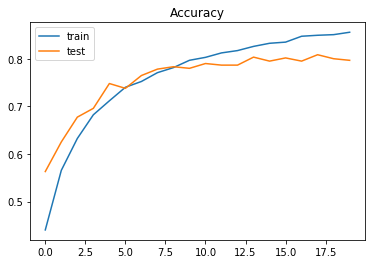

In [68]:
plt.title('Accuracy')
plt.plot(history_cat.history['accuracy'], label='train')
plt.plot(history_cat.history['val_accuracy'], label='test')
plt.legend()
plt.show()

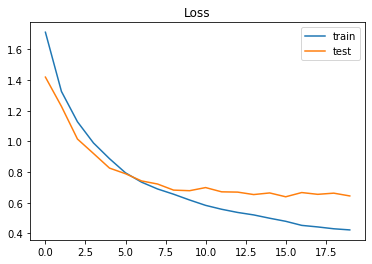

In [69]:
plt.title('Loss')
plt.plot(history_cat.history['loss'], label='train')
plt.plot(history_cat.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
categoryname = Y_cat_df.columns.tolist()
categoryname

In [131]:
# create confusion matrix for train data
from sklearn.metrics import confusion_matrix
from sklearn import metrics
train_prob = model_cat.predict(x_train_cat)
train_prob = (train_prob == train_prob.max(axis=1, keepdims=True)).astype(int)

print("Confusion Matrix:")
conf_mat_train = confusion_matrix(y_true=y_train_cat.argmax(axis=1), y_pred=train_prob.argmax(axis=1))
print(conf_mat_train)

print("Accuracy:", metrics.accuracy_score(y_train_cat, train_prob))

Confusion Matrix:
[[ 325    9   38   17   15    1    0   23    3]
 [   2  516    0    4    0    0    0    0    0]
 [  13    0  516   14   20    2    2   37   15]
 [   6    4   18 2578    5    6    0    3    2]
 [  13    2   62   22  609    7    1   30    4]
 [   0    1    7    4    4  135    0    7    6]
 [  28    8    4    4    6    1   28    3   10]
 [  16    4   55    8   11    8    0  129    8]
 [  10    3   40   12   11    8    9   43  367]]
Accuracy: 0.8756311006395153


In [132]:
# create confusion matrix for train data
test_prob = model_cat.predict(x_test_cat)
test_prob = (test_prob == test_prob.max(axis=1, keepdims=True)).astype(int)

print("Confusion Matrix:")
conf_mat_test = confusion_matrix(y_true=y_test_cat.argmax(axis=1), y_pred=test_prob.argmax(axis=1))
print(conf_mat_test)

print("Accuracy:", metrics.accuracy_score(y_test_cat, test_prob))

Confusion Matrix:
[[ 116   14   21   21    4    5    0   12    2]
 [   4  210    1    7    3    1    0    0    1]
 [  14    4  194   22   17    3    1   17    6]
 [   7    9   23 1049    7    4    1    2    3]
 [  11    2   37    9  234    6    1   10    9]
 [   1    1    3    4    0   68    0    3    2]
 [   6    2    3    2    4    3    2    1    5]
 [  10    2   17   13    3    2    0   52    5]
 [  12    6   17    9    3    5    5   24  128]]
Accuracy: 0.8060463290145269


The model predicts fairly on both train and dataset with accuracy level of 88% and 81% respectively. <br/>
By comparing the two confusion matrices, it can be inferred that: <br/>
-The model predicts most correctly on *Category 02, Category 04, Category 05* – the categories that have the
highest number of samples. <br/>
-The model tends to misclassify mostly among *Category 07, 08, 09 (same types of categories - Mouthwash)*. This can be understood that customers do not clearly specify features that differentiate the mouthwash collections, leading to the model finding it hard to assign the correct mouthwash collection.

#### Predict on Brandwatch
Apply the models to assign sentiment and product categories and prepare data for sentiment analysis.

In [114]:
# extract brandwatch data for BrandA only
bw_list = brandwatch.loc[brandwatch['brand']=='BrandA']

In [ ]:
# create independent var
X_bw_cat = tokenizer.texts_to_sequences(bw_list["reviewtext"])
print(X_bw_cat[0]) # print the first sequence of word indices
print(bw_list["reviewtext"].to_list()[0]) 

In [93]:
# Truncate and pad
maximum_tokens = 110
X_bw_cat = pad_sequences(X_bw_cat, maxlen=maximum_tokens) #110 as explained in previous section
print('Shape of data tensor:', X_bw_cat.shape)

Shape of data tensor: (50299, 110)


In [94]:
pred_cat = np.argmax(model_cat.predict(X_bw_cat),axis=-1)
pred_cat

array([5, 2, 0, ..., 3, 3, 5], dtype=int64)

In [ ]:
categoryname

In [115]:
bw_cat =[]
for i in range(0,len(pred_cat)):
    bw_cat.append(categoryname[pred_cat[i]])
bw_list['categoryname']=bw_cat

C:\Users\ntkcu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
bw_list['categoryname'].value_counts()

##### Refine datasets to have the final dataset for analysis

In [98]:
# bazarvoice dataset
bazar=bazar.drop_duplicates(subset=['reviewtext']) # didn't drop duplicates before modelling 
                                                   # to have more train data

In [99]:
bazar.shape

(7887, 10)

In [100]:
bz_cat = pd.DataFrame()
bz_cat['brand']=np.nan
bz_cat['date'],bz_cat['review'],bz_cat['categoryname'],bz_cat['sentiment'
    ] = bazar['lastmodificationtime'],bazar['reviewtext'],bazar['categoryname'],bazar['Sentiment']
bz_cat['brand']='BrandA'

In [101]:
bz_cat.shape

(7887, 5)

In [ ]:
bz_cat.head(2)

|brand|date|review|categoryname|sentiment|
|---|---|---|---|---|
BrandA|2020-06-27|We bought this product and absolutely love it...|Category 06|Positive
BrandA|2020-06-27|I figured I would weigh in here regarding...|Category 09|Negative

In [103]:
bz_cat = bz_cat.sort_values('date')

In [104]:
bz_cat.to_csv("bazar.csv")

In [117]:
# brandwatch dataset for BrandA only
bw_cat_df = pd.DataFrame()
bw_cat_df['brand']=np.nan
bw_cat_df['date'],bw_cat_df['review']=bw_list['date'],bw_list['reviewtext']
bw_cat_df['categoryname'] = bw_list['categoryname']
bw_cat_df['sentiment'] = bw_list['sentiment']
bw_cat_df['brand']='BrandA'

In [ ]:
bw_cat_df.head(2)

|brand|date|review|categoryname|sentiment|
|---|---|---|---|---|
BrandA|2018-10-29|his aa sponsor is texting him encouraging plat...|Category 06|Neutral
BrandA|2020-03-08|aaaa I tried to suppress a sneeze...|Category 03|Neutral

In [119]:
bw_cat_df.shape

(50299, 5)

In [123]:
# brandwatch dataset for remaining brands
other_list = brandwatch.loc[brandwatch['brand']!='BrandA']
other_list = other_list[['brand','date','reviewtext','sentiment']]
other_list = other_list.rename(columns={'reviewtext': 'review'})
other_list.shape

(81974, 4)

In [ ]:
other_list.head(2)

|brand|date|review|sentiment|
|---|---|---|---|
BrandX|2020-01-12|abc and cnn s repo ing was definitely skewed t...|Neutral
BrandX|20219-07-25|the ability to solve a problem act on it rin...|Neutral

In [125]:
# combine for final dataset
final_data = pd.concat([bz_cat,bw_cat_df,other_list])
final_data = final_data.sort_values('date').reset_index(drop=True)

In [126]:
final_data.shape

(140160, 5)

In [ ]:
final_data.head(2)

|brand|date|review|categoryname|sentiment|
|---|---|---|---|---|
BrandA|2018-01-01|gargle with branda|Category 01|Neutral
BrandA|2018-01-01|lol the guy swigs it from his local cvs...|Category 04|Neutral

In [129]:
final_data['sentiment'].value_counts()

Neutral     127488
Positive     10866
Negative      1806
Name: sentiment, dtype: int64

In [130]:
# print to file
final_data.to_csv("final_data.csv")

### Sentiment Analysis on Topics
The team performed further analysis to find out the features in BrandA and other brands that are discussed most frequently in reviews for better insights, based on which the team can give strategic recommendations. LDA model was applied in this analysis. The team only used Positive and Negative reviews for this analysis. We will separate positive and negative reviews to extract topics that receive good feedbacks and those with complaints.

In [23]:
final_data['sentiment'].value_counts()

Neutral     127488
Positive     10866
Negative      1806
Name: sentiment, dtype: int64

In [25]:
selected_review = final_data.loc[(final_data['sentiment'] == 'Positive') | (final_data['sentiment'] == 'Negative')]

#### Clean text data
We performed data cleaning again to prepare for LDA modelling.

In [26]:
# lowercase 'reviewtext' - prepare for stopwords step
selected_review["review_lower"] = selected_review["review"].str.lower()
# change '0' to 'zero' before we remove all numbers; make the change only if '0' is surrounded by spaces
selected_review["review_clean"] = selected_review["review_lower"].apply(lambda x: re.sub('\s+[0]\s+',' zero ',str(x)))
# remove all characters except for letters
selected_review["review_clean"] = selected_review["review_clean"].apply(lambda x: re.sub('[^a-zA-Z]',' ',x))

C:\Users\ntkcu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ntkcu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ntkcu\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Because LDA will extract words from the data, based on which we can learn about popular product features, the team tried to remove as many unuseful words as possible. For example, brand names, 'use', 'product' are used a lot but are of no use to interpretation and thus, should be removed. Or, words like 'great','good' may be useful for sentiment analysis, but not useful for topic analysis cos' the team already separated positive and negative reviews, and thus, will be removed. <br/>
To remove unuseful words that appear a lot in the datasets, we can use counter function to check word count. However, we chose to create a word cloud to better visualization. We based on the word cloud to add more unuseful words to the stop words list.

In [ ]:
# download the stopwords dictionary
from nltk.corpus import stopwords
nltk.download('stopwords')

# save the list of stopwords in stop_words
sw = stopwords.words('english')

# add extra words to the stopwords dictionary #after checking the list of stopwords
new_stopwords = ['guys','could', 'can t',"can't",'dont',
                 'tbh','b','c','e','f','g','h','j','k','l','n','p','q','r','u','v','w','x','z','da','lol',
                 'brand name','product','use','thi','one','think','make','year','try','great','well','good',
                 'love','work','really','much','thank','say','like','wow','ok','yes','thanks'] #to be added
sw.extend(new_stopwords)

# remove the words that exist in the stopwords dictionary from tweets
selected_review["review_clean_no_stop_words"] = selected_review["review_clean"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in sw))
selected_review.head(2)

##### Lemmatization while including POS tagging

In [ ]:
# code taken from here: https://stackoverflow.com/questions/51267166/lemmatization-pandas-python
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)



# Lemmatizing using POS (Part of Speech) tagging
selected_review['lemmatized_review'] = selected_review['review_clean_no_stop_words'].apply(lambda x: lemmatize_sentence(x))
selected_review.head(2)

In [ ]:
# Remove stop word one more time - after lemmatization, many words are lemmatized to stop words (e.g. use)
selected_review["lemmatized_review"] = selected_review['lemmatized_review'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in sw))
selected_review.head(2)

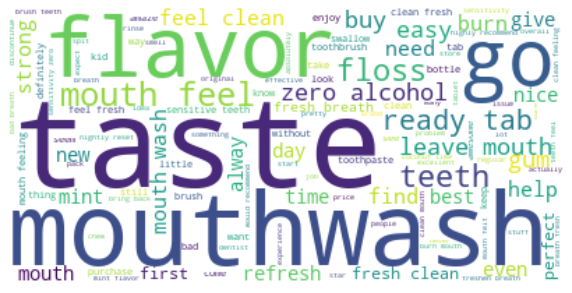

In [81]:
#!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_wc = " ".join(item for item in selected_review['lemmatized_review'])
wordcloud = WordCloud(background_color="white").generate(text_wc)
# show the wordcloud using matplotlib; check more here: https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show() 

There are 21 brands in total in the datasets, but some brands have very few data. Thus, the team filtered and analyzed the top 5 popular brands only: the main brand - BrandA and 4 other brands. <br/>
The team analyzed both topics with positive feedbacks and complaints. Concerning other brands, only topics with positive feedbacks were analyzed for comparison. Recommendations were given based on the analysis results. <br/>
Within the scope of this notebook, I will demonstrate the analysis for topics with positive reviews for 1 brand - BrandA only. We did the same for negative reviews of Brand A and for analysis on other brands.

In [82]:
# keep only top 5 brands. top 5 brands have more than 300 reviews
from collections import Counter

counts = Counter(selected_review.brand)
popular_brand = selected_review[selected_review.brand.isin([key for key in counts if counts[key] > 300])]

In [83]:
BrandA = popular_brand.loc[popular_brand["brand"] == "BrandA"]
BrandA.shape

(8874, 9)

##### Separate Positive and Negative Review

In [84]:
BrandA_Pos_Review = BrandA.loc[BrandA['sentiment'] == 'Positive']
BrandA_Neg_Review = BrandA.loc[BrandA['sentiment'] == 'Negative']

In [85]:
BrandA_Pos_Review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7427 entries, 85 to 140159
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   brand                       7427 non-null   object
 1   date                        7427 non-null   object
 2   review                      7427 non-null   object
 3   categoryname                7427 non-null   object
 4   sentiment                   7427 non-null   object
 5   review_lower                7427 non-null   object
 6   review_clean                7427 non-null   object
 7   review_clean_no_stop_words  7427 non-null   object
 8   lemmatized_review           7427 non-null   object
dtypes: object(9)
memory usage: 580.2+ KB


##### Create Word matrix

In [86]:
from sklearn.feature_extraction.text import CountVectorizer

BrandA_Posi_count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
BrandA_Nega_count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')

BrandA_Pos_dtm = BrandA_Posi_count_vect.fit_transform(BrandA_Pos_Review["lemmatized_review"].values.astype('U'))
BrandA_Neg_dtm = BrandA_Nega_count_vect.fit_transform(BrandA_Neg_Review["lemmatized_review"].values.astype('U'))

In [87]:
BrandA_Pos_dtm

<7427x2731 sparse matrix of type '<class 'numpy.int64'>'
	with 77303 stored elements in Compressed Sparse Row format>

##### LDA Model for Positive Review
[Ref Link](https://stackabuse.com/python-for-nlp-topic-modeling/)

In [90]:
from sklearn.decomposition import LatentDirichletAllocation

BrandA_Pos_LDA = LatentDirichletAllocation(n_components=7, random_state=42)
BrandA_Pos_LDA.fit(BrandA_Pos_dtm)

LatentDirichletAllocation(n_components=7, random_state=42)

In [91]:
for i,topic in enumerate(BrandA_Pos_LDA.components_):
    print(f'Top 10 words for BrandA Positive topic #{i+1}:')
    print([BrandA_Posi_count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for BrandA Positive topic #1:
['felt', 'refresh', 'feeling', 'breath', 'taste', 'leave', 'feel', 'fresh', 'clean', 'mouth']


Top 10 words for BrandA Positive topic #2:
['convenient', 'freshen', 'liquid', 'swallow', 'chew', 'easy', 'mint', 'ready', 'breath', 'tab']


Top 10 words for BrandA Positive topic #3:
['buy', 'dental', 'gum', 'teeth', 'discontinue', 'mint', 'bring', 'store', 'best', 'floss']


Top 10 words for BrandA Positive topic #4:
['rinse', 'therapy', 'flavor', 'sensitive', 'kid', 'care', 'help', 'teeth', 'mouthwash', 'gum']


Top 10 words for BrandA Positive topic #5:
['sensitive', 'teeth', 'sensitivity', 'mouth', 'flavor', 'zero', 'burn', 'taste', 'mouthwash', 'alcohol']


Top 10 words for BrandA Positive topic #6:
['night', 'recommend', 'reset', 'morning', 'nightly', 'definitely', 'mouthwash', 'teeth', 'feel', 'mouth']


Top 10 words for BrandA Positive topic #7:
['little', 'people', 'freshness', 'bottle', 'flavor', 'long', 'water', 'teeth', 'time', 'taste'

##### Positive Topic Intepretation:
* Topic 1: Clean and Freshness
* Topic 2: Chewability/Swallowability
* Topic 3: Convenience to store and bring
* Topic 4: Kid-friendly
* Topic 5: No alcohol
* Topic 6: Routine with * *(a specific product category with routine)*
* Topic 7: Product taste

#### Assign topic for each review

In [92]:
BrandA_Pos_topic_values = BrandA_Pos_LDA.transform(BrandA_Pos_dtm)
BrandA_Pos_topic_values.shape

(7427, 7)

In [93]:
BrandA_Pos_Review['topic'] = BrandA_Pos_topic_values.argmax(axis=1)

C:\Users\ntkcu\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
BrandA_Pos_Review.head(2)

#### Summarization

In [95]:
BrandA_Pos_Review['topic'].value_counts()

0    1815
1    1430
4    1106
2     903
5     872
3     846
6     455
Name: topic, dtype: int64

[Text(0, 0, 'Clean&Fresh'),
 Text(0, 0, 'Chewing'),
 Text(0, 0, 'Store&Bring'),
 Text(0, 0, 'Kid-friendly'),
 Text(0, 0, 'No alcohol'),
 Text(0, 0, 'Routine'),
 Text(0, 0, 'Taste')]

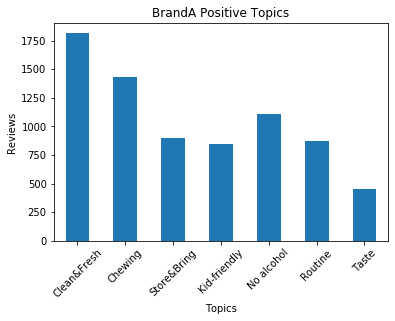

In [97]:
pos_chart = BrandA_Pos_Review['topic'].value_counts().sort_index().plot(kind='bar')
pos_chart.set_title('BrandA Positive Topics')
pos_chart.set_xlabel('Topics')
pos_chart.set_ylabel('Reviews')

pos_chart.set_xticks(range(0,7))
topics = ['Clean&Fresh','Chewing','Store&Bring','Kid-friendly','No alcohol','Routine','Taste']
pos_chart.set_xticklabels(topics,rotation=45)

### LIMITATION
Despite great efforts in performing this analysis, the team still encountered with several limitations.
- The amount of data used in analysis into top product features is limited, since most texts in Brandwatch dataset are assigned as neutral (nearly 90%). As part of this analysis, only 12,000 positive and negative reviews in 3 selected consecutive years were used, which means that there is a risk that the team could not cover several important features that the data could not capture.
- The assignment of product categories to BrandA texts in Brandwatch beas some limitation since the team could not check the accuracy of category prediction. Due to limited knowledge of all the covered product categories, the team found it difficult to correctly assign categories manually by ourselves; therefore, the team had to completely relied on the model for this assignment.